In [46]:
"""
Loan Default Prediction Pipeline
================================
Predicts whether a loan will be 'Fully Paid' or 'Charged Off'.
Uses SMOTENC, stacking ensemble, threshold tuning, and robust evaluation.
"""

import pandas as pd
import numpy as np
import joblib
import os
from pathlib import Path

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# IMBALANCED-LEARN
from imblearn.over_sampling import SMOTENC

# MODELS
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# PLOTTING
import matplotlib.pyplot as plt

# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')


In [52]:

class FastLoanDefaultPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.categorical_columns = [
            'term', 'emp_length', 'home_ownership', 'verification_status',
            'purpose', 'application_type'
        ]
        self.numerical_columns_ = None
        self.best_threshold = 0.5

    def load_data(self, file_path, n_rows=None):
        """Load data, optionally sample for speed."""
        print("📂 Loading data...")
        df = pd.read_csv(file_path, usecols=[
            'loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
            'open_acc', 'revol_util', 'total_acc', 'application_type', 'loan_status'
        ], low_memory=False, nrows=n_rows)  # Limit rows for speed
        return df

    def feature_engineering(self, df):
        """Create new features."""
        print("🔧 Feature engineering...")
        df['income_to_loan_ratio'] = df['annual_inc'] / (df['loan_amnt'] + 1)
        df['dti_to_inc_ratio'] = df['dti'] / (df['annual_inc'] + 1)
        df['log_annual_inc'] = np.log1p(df['annual_inc'])
        # Safe extraction of term
        df['term_months'] = pd.to_numeric(
            df['term'].str.extract(r'(\d+)')[0], errors='coerce'
        ).astype('Int64')
        df['term_months'].fillna(df['term_months'].median(), inplace=True)
        return df

    def clean_data(self, df):
        """Filter and encode target."""
        print("🧹 Cleaning data...")
        df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
        df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

        for col in df.select_dtypes(include='number').columns:
            df[col].fillna(df[col].median(), inplace=True)
        for col in df.select_dtypes(include='object').columns:
            df[col].fillna(df[col].mode()[0], inplace=True)

        return df

    def preprocess(self, df):
        """One-hot encode categoricals."""
        print("🏷️ Encoding categoricals...")
        df = pd.get_dummies(df, columns=self.categorical_columns, drop_first=True)
        return df

    def scale_features(self, X_train, X_test):
        """Scale only numerical features."""
        print("📐 Scaling numericals...")
        self.numerical_columns_ = X_train.select_dtypes(include='number').columns
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        X_train_scaled[self.numerical_columns_] = self.scaler.fit_transform(
            X_train[self.numerical_columns_]
        )
        X_test_scaled[self.numerical_columns_] = self.scaler.transform(
            X_test[self.numerical_columns_]
        )
        # Convert scaled arrays back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

        X_train_scaled.columns = X_train_scaled.columns.str.replace(r'[\[\]<>\s]', '_', regex=True)
        X_test_scaled.columns = X_test_scaled.columns.str.replace(r'[\[\]<>\s]', '_', regex=True)
        return X_train_scaled, X_test_scaled

    def train(self, X_train, y_train):
        """Train fast stacking model using class_weight instead of SMOTE."""
        print("🏋️ Training fast model...")

        # Base models: lighter & faster
        xgb_clf = XGBClassifier(
            learning_rate=0.1,
            max_depth=4,
            n_estimators=100,
            scale_pos_weight=float(sum(y_train == 0) / sum(y_train == 1)),  # Auto balance
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss',
            use_label_encoder=False
        )

        lgbm_clf = LGBMClassifier(
            learning_rate=0.1,
            max_depth=4,
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )

        cat_clf = CatBoostClassifier(
            depth=4,
            learning_rate=0.1,
            iterations=100,
            class_weights=[1, sum(y_train==0)/sum(y_train==1)],
            verbose=0,
            random_state=42
        )

        # Final estimator
        final_estimator = LogisticRegression(max_iter=1000)

        # Stacking with 3-fold CV (faster than 5)
        self.model = StackingClassifier(
            estimators=[
                ('xgb', xgb_clf),
                ('lgbm', lgbm_clf),
                ('cat', cat_clf)
            ],
            final_estimator=final_estimator,
            cv=3,  # Faster: 3 folds instead of 5
            passthrough=True,
            n_jobs=-1
        )

        self.model.fit(X_train, y_train)
        print("✅ Fast model training complete.")

    def optimize_threshold(self, y_true, y_proba):
        """Find best F1 threshold."""
        prec, rec, thres = precision_recall_curve(y_true, y_proba)
        f1 = 2 * prec * rec / (prec + rec + 1e-6)
        best_idx = np.argmax(f1)
        self.best_threshold = thres[best_idx]
        print(f"🎯 Best threshold: {self.best_threshold:.4f}")
        return self.best_threshold

    def evaluate(self, X_test, y_test):
        """Evaluate with plots."""
        print("📊 Evaluating...")
        y_proba = self.model.predict_proba(X_test)[:, 1]
        self.optimize_threshold(y_test, y_proba)
        y_pred = (y_proba >= self.best_threshold).astype(int)

        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))

        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"\n📈 ROC-AUC: {roc_auc:.4f}")

        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        ax[0].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
        ax[0].plot([0,1],[0,1], '--', c='gray')
        ax[0].set_title("ROC Curve"); ax[0].legend(); ax[0].grid(True)

        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = np.trapz(prec[::-1], rec[::-1])
        ax[1].plot(rec, prec, label=f'PR AUC = {pr_auc:.4f}')
        ax[1].set_title("Precision-Recall Curve"); ax[1].legend(); ax[1].grid(True)
        plt.tight_layout(); plt.show()

        return {'y_proba': y_proba, 'y_pred': y_pred, 'roc_auc': roc_auc}

    def save_model(self, save_dir="models_fast"):
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(self.model, f"{save_dir}/stacking_model.pkl")
        joblib.dump(self.scaler, f"{save_dir}/scaler.pkl")
        joblib.dump({
            'best_threshold': self.best_threshold,
            'numerical_columns': self.numerical_columns_.tolist()
        }, f"{save_dir}/config.pkl")
        print(f"💾 Model saved to: {os.path.abspath(save_dir)}")


📂 Loading data...
🔧 Feature engineering...
🧹 Cleaning data...
🏷️ Encoding categoricals...
📐 Scaling numericals...
🏋️ Training fast model...
✅ Fast model training complete.
📊 Evaluating...
🎯 Best threshold: 0.2278

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81     28199
           1       0.37      0.61      0.46      7018

    accuracy                           0.72     35217
   macro avg       0.63      0.68      0.63     35217
weighted avg       0.78      0.72      0.74     35217


📈 ROC-AUC: 0.7428


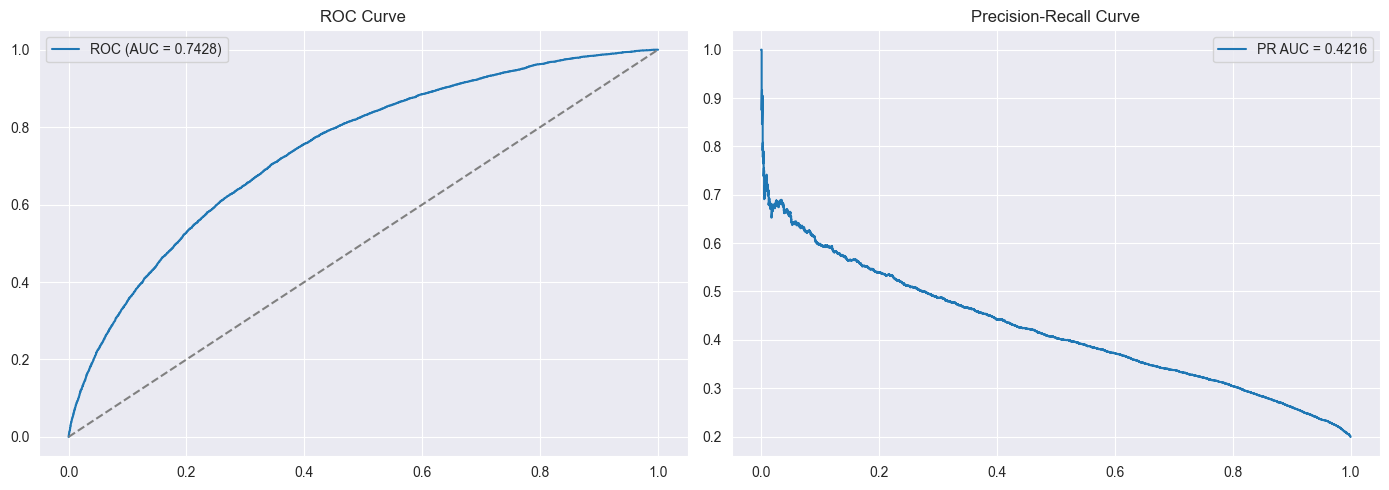

💾 Model saved to: C:\Users\Mahen\PycharmProjects\pythonProject20\loan default prediction\notebooks\models_fast


In [53]:
if __name__ == "__main__":
    predictor = FastLoanDefaultPredictor()

    # 🔽 Optional: Load only 200K rows for fast training
    DATA_PATH = r"E:/data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv"
    df = predictor.load_data(DATA_PATH, n_rows=200000)  # Remove n_rows for full data

    df = predictor.feature_engineering(df)
    df = predictor.clean_data(df)
    df = predictor.preprocess(df)

    X = df.drop('loan_status', axis=1)
    y = df['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    X_train_scaled, X_test_scaled = predictor.scale_features(X_train, X_test)

    predictor.train(X_train_scaled, y_train)
    results = predictor.evaluate(X_test_scaled, y_test)
    predictor.save_model()